In [3]:
%load_ext autoreload
%autoreload 2

In [8]:
import os
os.environ['JAX_PLATFORM_NAME']='cpu'
import sys
sys.path.append('/home/xmax/projects/nn_ansatz/src')
import jax
from jax.tree_util import tree_flatten

import numpy as np
from nn_ansatz import *
from nn_ansatz import run_vmc

import jax.numpy as jnp
from tqdm.notebook import trange
from jax import lax

import matplotlib.pyplot as plt
from matplotlib import cm
from jax.experimental.optimizers import adam

lr, damping, nc = 1e-4, 1e-4, 1e-4


In [9]:
def save_pk(x, path):
    with open(path, 'wb') as f:
        pk.dump(x, f)
    

In [10]:
cfg = setup(system='LiSolid',
               n_pre_it=501,
               n_walkers=512,
               n_layers=2,
               n_sh=32,
               n_ph=8,
               opt='kfac',
               n_det=4,
               print_every=1,
               save_every=1000,
               lr=1e-3,
               n_it=100,
               norm_constraint=1e-4,
               damping=1e-3,
               distribute=True,
               kappa = 0.5,
               real_cut = 5,
               reciprocal_cut = 5,
               n_periodic_input = 2,
               exp=True)
            #    name='scalar_inputs',
            #    scalar_inputs=True)

logger = Logging(**cfg)

keys = rnd.PRNGKey(cfg['seed'])
if bool(os.environ.get('DISTRIBUTE')) is True:
    keys = rnd.split(keys, cfg['n_devices']).reshape(cfg['n_devices'], 2)

mol = SystemAnsatz(**cfg)
print(type(cfg['real_basis']))
test = load_pk(os.path.join(cfg['exp_dir'], 'config1.pk'))
print(type(test['real_basis']))

vwf = create_wf(mol)
params = initialise_params(mol, keys)

sampler = create_sampler(mol, vwf)

# walkers = load_pk('./walkers_no_infs.pk')
walkers = initialise_walkers(mol, vwf, sampler, params, keys, walkers=None)
save_pk(walkers, './walkers_no_infs.pk')

grad_fn = create_grad_function(mol, vwf)

if cfg['opt'] == 'kfac':
    update, get_params, kfac_update, state = kfac(mol, params, walkers, cfg['lr'], cfg['damping'], cfg['norm_constraint'])
else:
    print('using adam')
    init, update, get_params = adam(cfg['lr'])
    update = jit(update)
    state = init(params)

steps = trange(0, 1001, initial=0, total=cfg['n_it'], desc='training', disable=None)
step_size = split_variables_for_pmap(cfg['n_devices'], cfg['step_size'])

all_walkers = []
for step in steps:
    keys, subkeys = key_gen(keys)

    walkers, acceptance, step_size = sampler(params, walkers, subkeys, step_size)

    grads, e_locs = grad_fn(params, walkers)
    e_mean = jnp.mean(e_locs)

    if jnp.isnan(e_mean):
        print('break 1')
        break

    kfac_grads, state = kfac_update(step, grads, state, walkers)

    old_params = get_params(state)
    state = update(step, kfac_grads, state)
    params = get_params(state)

    steps.set_postfix(E=f'{e_mean:.6f}')
    steps.refresh()

    logger.log(step,
                opt_state=state,
                params=params,
                e_locs=e_locs,
                acceptance=acceptance[0])

    _walkers = walkers
    _grads = grads
    _kfac_grads = kfac_grads
    _state = state
    _params = params
    _e_locs = e_locs
    
    # ae_vector = compute_ae_vectors_i(walkers, mol.r_atoms, mol.real_basis, mol.inv_real_basis)
    # ae_vector_periodic = apply_minimum_image_convention(ae_vector, mol.real_basis, mol.inv_real_basis)
    # boundary = mol.min_cell_width / 2.
    # ae_vector_outside_boundary = jnp.abs(ae_vector_periodic) > boundary

    # ae_vector_new = jnp.where(ae_vector_periodic < -boundary/2., -1./(8.*(mol.min_cell_width + 2.*ae_vector_periodic)), ae_vector_periodic)
    # ae_vector_new = jnp.where(ae_vector_new > boundary/2., 1./(8.*(mol.min_cell_width - 2.*ae_vector_new)), ae_vector_new)

    # ae_vector_periodic_fn = compute_ae_vectors_periodic_i(walkers, mol.r_atoms, mol.real_basis, mol.inv_real_basis) 
    # assert not ae_vector_outside_boundary



version 		 240621
seed 		 369
n_devices 		 1
save_every 		 1000
print_every 		 1
exp_dir 		 /home/xmax/projects/nn_ansatz/src/scripts/debugging/validation/experiments/LiSolid/240621/kfac_1lr-3_1d-3_1nc-4_m512_s32_p8_l2_det4/run3
events_dir 		 /home/xmax/projects/nn_ansatz/src/scripts/debugging/validation/experiments/LiSolid/240621/kfac_1lr-3_1d-3_1nc-4_m512_s32_p8_l2_det4/run3/events
models_dir 		 /home/xmax/projects/nn_ansatz/src/scripts/debugging/validation/experiments/LiSolid/240621/kfac_1lr-3_1d-3_1nc-4_m512_s32_p8_l2_det4/run3/models
opt_state_dir 		 /home/xmax/projects/nn_ansatz/src/scripts/debugging/validation/experiments/LiSolid/240621/kfac_1lr-3_1d-3_1nc-4_m512_s32_p8_l2_det4/run3/models/opt_state
pre_path 		 /home/xmax/projects/nn_ansatz/src/scripts/debugging/validation/experiments/LiSolid/pretrained/s32_p8_l2_det4_1lr-4_i501.pk
timing_dir 		 /home/xmax/projects/nn_ansatz/src/scripts/debugging/validation/experiments/LiSolid/240621/kfac_1lr-3_1d-3_1nc-4_m512_s32_p8_l2_det4/run

training:   0%|          | 0/100 [00:00<?, ?it/s]

step 0 | e_mean -12.0031 | e_std 79.8768 | e_mean_mean -12.0031 | acceptance 0.8777 |
step 1 | e_mean -2.5506 | e_std 46.9949 | e_mean_mean -7.2768 | acceptance 0.8766 |
step 2 | e_mean -2.5507 | e_std 32.0669 | e_mean_mean -5.7014 | acceptance 0.8744 |
step 3 | e_mean -0.5057 | e_std 18.7206 | e_mean_mean -4.4025 | acceptance 0.8773 | t_per_it 1624528512.9824 |
step 4 | e_mean -1.3206 | e_std 37.4072 | e_mean_mean -3.7861 | acceptance 0.8775 | t_per_it 0.1325 |
step 5 | e_mean -1.3333 | e_std 28.7429 | e_mean_mean -3.3773 | acceptance 0.8789 | t_per_it 0.1751 |
step 6 | e_mean -0.6150 | e_std 42.6332 | e_mean_mean -2.9827 | acceptance 0.8754 | t_per_it 0.2056 |
step 7 | e_mean -0.2375 | e_std 14.2218 | e_mean_mean -2.6396 | acceptance 0.8756 | t_per_it 0.2274 |
step 8 | e_mean -0.2422 | e_std 10.9715 | e_mean_mean -2.3732 | acceptance 0.8816 | t_per_it 0.2340 |
step 9 | e_mean -2.0801 | e_std 19.5410 | e_mean_mean -2.0801 | acceptance 0.8799 | t_per_it 0.2434 |
step 10 | e_mean -1.177

System: 
 n_atoms = 1 
 n_up    = 2 
 n_down  = 1 
 n_el    = 3 

Ansatz: 
 n_layers = 2 
 n_det    = 4 
 n_sh     = 32 
 n_ph     = 8 

Cell: 
 real_basis: 
 [[ 5.6081324  0.         0.       ]
 [-1.8693775  5.287398   0.       ]
 [-1.8693775 -2.6436992  4.5790205]] 
 reciprocal_basis: 
 [[ 1.1203705   0.39611074  0.6860841 ]
 [-0.          1.1883323   0.6860841 ]
 [ 0.         -0.          1.3721681 ]] 
 real_cut         = 5.00 
 reciprocal_cut   = 5 
 kappa            = 0.50 
 volume           = 135.78 
 min_cell_width   = 4.58 
 n_periodic_input = 2 

converged SCF energy = -7.31552598128109
creating wf


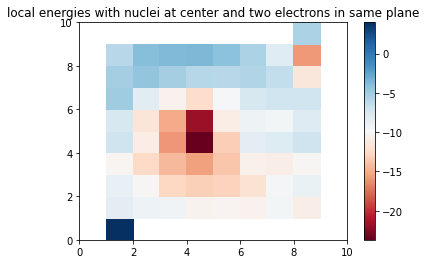

[       nan 3.96979141        nan        nan        nan        nan
        nan        nan        nan        nan]
[         nan  -8.42011452  -9.01248741  -9.29623985 -10.37403297
 -10.26008415 -10.47019005  -9.52057838 -10.73620033          nan]
[         nan  -8.77559471 -10.07320213 -12.68213844 -13.20470238
 -13.06777954 -11.90423393  -9.64509773  -8.95237923          nan]
[         nan -10.13967705 -12.62364006 -14.29890251 -15.5291214
 -13.64892006 -10.51387978 -10.73778725 -10.07177162          nan]
[         nan  -6.97364044 -10.92844582 -15.93223572 -23.69356918
 -13.26725197  -8.35093498  -8.00424385  -6.96459198          nan]
[         nan  -7.53400993 -11.68330193 -15.07448387 -21.75488853
 -10.88818932  -9.1998539   -9.51255608  -8.05439568          nan]
[         nan  -4.91318512  -8.31590462 -10.44601631 -12.35443115
  -9.69184303  -7.53709602  -7.11475372  -7.12583542          nan]
[         nan  -5.14712143  -4.38764954  -5.2060318   -5.92338181
  -6.00979233  -5.741096

In [99]:
# fix 2 and move the other across a slice that intersects with the atom also put the electrons in the same plane
mcw = mol.min_cell_width
rx0, ry0, rz0 = mol.r_atoms[0]
n_samples = 10
width = mcw/2
X = np.linspace(-width+rx0, width+rx0, n_samples)
Y = np.linspace(-width+ry0, width+ry0, n_samples)
XX, YY = np.meshgrid(X, Y)
Z = mol.r_atoms[0, -1]

x2, x3 = [float(np.random.normal(mol.r_atoms[0, 0], 0.1)) for i in range(2)]
y2, y3 = [float(np.random.normal(mol.r_atoms[0, 1], 0.1)) for i in range(2)]

paths = ['/home/xmax/projects/nn_ansatz/src/scripts/debugging/validation/experiments/LiSolid/sin2/kfac_1lr-3_1d-3_1nc-4_m512_s32_p8_l2_det4/run1',
         '/home/xmax/projects/nn_ansatz/src/scripts/debugging/validation/experiments/LiSolid/scalar_inputs/kfac_1lr-3_1d-3_1nc-4_m512_s32_p8_l2_det4/run0']

i = 0
cfg = load_config_pk(os.path.join(paths[i], 'config1.pk'))
mol = SystemAnsatz(**cfg)
vwf = create_wf(mol)
params = load_pk(os.path.join(paths[i], 'models', 'i1000.pk'))

compute_energy = create_energy_fn(mol, vwf)

data = []
for x1 in X:
    for y1 in Y:
        walker = jnp.array([[[x1, y1, Z], [x2, y2, Z], [x3, y3, Z]]])
        local_energy = compute_energy(params, walker)

        data.append([x1, y1, Z, float(local_energy)])

data = pd.DataFrame(data, columns=['x','y','z','local_energy'])

plot_data = data.pivot(index='x', columns='y', values='local_energy')

fig, ax = plt.subplots()

# ax.pcolor(XX, YY, plot_data.values, cmap=cm.RdBu, vmin=plot_data.min().min(), vmax=plot_data.max().max(), shading='auto')
plot_data = plot_data.to_numpy()
m = np.ma.masked_where(np.isnan(plot_data),plot_data)
p = ax.pcolor(m, cmap=cm.RdBu, vmin=m.min(), vmax=m.max(), shading='auto')
cb = fig.colorbar(p, ax=ax)

ax.set_title('local energies with nuclei at center and two electrons in same plane')
plt.show()

for r in plot_data:
    print(r)

# create the meshgrid
# X, Y = np.meshgrid(real_cuts, reciprocal_cuts)
# for kappa in kappas:
#     print('kappa: ', kappa)
#     fig, axs = plt.subplots(1, 3, figsize=(14, 4))  
#     for z, ax in zip(['real', 'reciprocal', 'potential'], axs):
#         plot_data = data[data.kappa == kappa].pivot(index='reciprocal_cut', columns='real_cut', values=z)
#         p = ax.pcolor(X, Y, plot_data.values, cmap=cm.RdBu, vmin=plot_data.min().min(), vmax=plot_data.max().max(), shading='auto')
#         ax.set_xlabel('real cut')
#         ax.set_ylabel('reciprocal cut')
#         if z == 'real': z = 'real (mean = %.3f, std = %.2f)' % (np.mean(plot_data.values), np.std(plot_data.values))
#         ax.set_title(z)
#         cb = fig.colorbar(p, ax=ax)
#     fig.suptitle('k = %.2f, min energy = %.6f / max energy  = %.6f' % (kappa, plot_data.min().min(), plot_data.max().max()))
#     fig.tight_layout()


In [10]:

paths = ['/home/xmax/projects/nn_ansatz/src/scripts/debugging/validation/experiments/LiSolid/sin2/kfac_1lr-3_1d-3_1nc-4_m512_s32_p8_l2_det4/run1',
         '/home/xmax/projects/nn_ansatz/src/scripts/debugging/validation/experiments/LiSolid/scalar_inputs/kfac_1lr-3_1d-3_1nc-4_m512_s32_p8_l2_det4/run0']

i = 0
cfg = load_config_pk(os.path.join(paths[i], 'config1.pk'))
mol = SystemAnsatz(**cfg)
vwf = create_wf(mol)
params = load_pk(os.path.join(paths[i], 'models', 'i1000.pk'))

jvwf = jit(vwf)
compute_energy = create_energy_fn(mol, vwf)

System: 
 n_atoms = 1 
 n_up    = 2 
 n_down  = 1 
 n_el    = 3 

Ansatz: 
 n_layers = 2 
 n_det    = 4 
 n_sh     = 32 
 n_ph     = 8 

Cell: 
 real_basis: 
 [[ 5.6081324  0.         0.       ]
 [-1.8693775  5.287398   0.       ]
 [-1.8693775 -2.6436992  4.5790205]] 
 reciprocal_basis: 
 [[ 1.1203705   0.39611074  0.6860841 ]
 [-0.          1.1883323   0.6860841 ]
 [ 0.         -0.          1.3721681 ]] 
 real_cut         = 5.00 
 reciprocal_cut   = 5 
 kappa            = 0.50 
 volume           = 135.78 
 min_cell_width   = 4.58 
 n_periodic_input = 2 

converged SCF energy = -7.31552598128109
creating wf


In [11]:
# fix 2 and move the other across a slice that intersects with the atom also put the electrons in the same plane


mcw = mol.min_cell_width
ucw = mol.unit_cell_length
rx0, ry0, rz0 = mol.r_atoms[0]
n_samples = 1000
width = mcw
X = np.linspace(-width+rx0, width+rx0, n_samples)
Y = np.linspace(-width+ry0, width+ry0, n_samples)
XX, YY = np.meshgrid(X, Y)

x2, x3 = [float(np.random.normal(mol.r_atoms[0, 0], 0.1)) for i in range(2)]
y2, y3 = [float(np.random.normal(mol.r_atoms[0, 1], 0.1)) for i in range(2)]
z2, z3 = [float(np.random.normal(mol.r_atoms[0, 2], 0.1)) for i in range(2)]




def pbc(walkers, real_basis, inv_real_basis):
    talkers = walkers.dot(inv_real_basis)
    talkers = jnp.fmod(talkers, 1.)
    talkers = jnp.where(talkers < 0., talkers + 1., talkers)
    talkers = talkers.dot(real_basis)   
    return talkers

data_tmp = []
for x1 in X:
    walker = jnp.array([[[x1, ry0, rz0], [x2, y2, z2], [x3, y3, z3]]])

    walker = pbc(walker, mol.real_basis, mol.inv_real_basis)
    log_psi = jvwf(params, walker)
    
    local_energy = compute_energy(params, walker)
    tmp = [x1, float(walker[0, 0, 0]), local_energy, log_psi]
    data_tmp.append(tmp)

    


data = np.array(data_tmp)



plt.show()

ipykernel_launcher:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


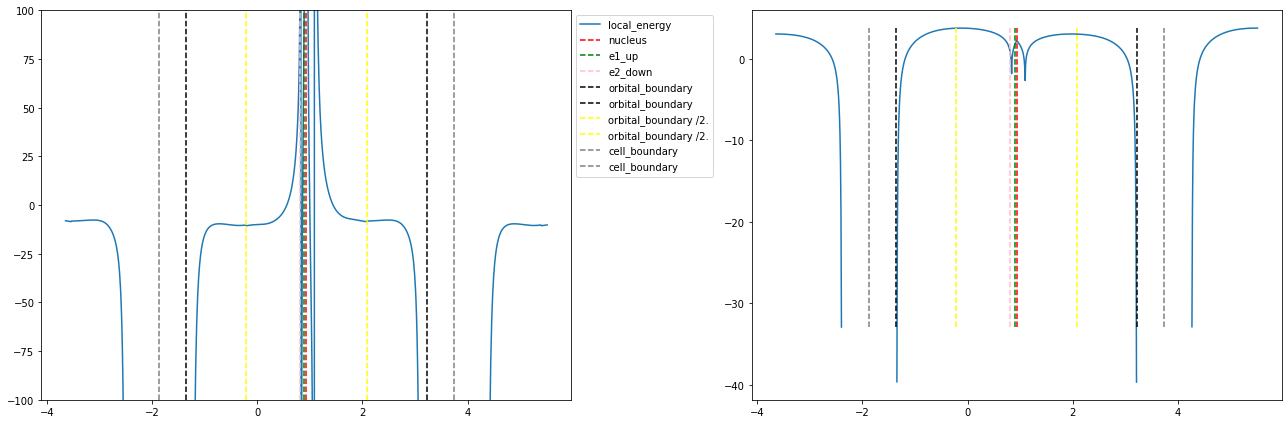

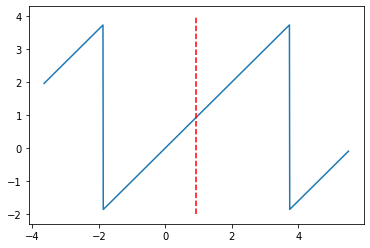

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
# np.ma.masked_where(np.isnan(plot_data),plot_data)
energy_data = data[:, 2]
axs[0].plot(X, energy_data, label='local_energy')
ymax, ymin = energy_data.max(), energy_data.min()
ymax, ymin = 100, -100
y_line = np.linspace(ymin, ymax, 10)
axs[0].plot([rx0 for _ in y_line], y_line, color='r', ls='--', label='nucleus')
axs[0].plot([x2 for _ in y_line], y_line, color='g', ls='--', label='e1_up')
axs[0].plot([x3 for _ in y_line], y_line, color='pink', ls='--', label='e2_down')
axs[0].plot([rx0-mcw/2 for _ in y_line], y_line, color='black', ls='--', label='orbital_boundary')
axs[0].plot([rx0+mcw/2 for _ in y_line], y_line, color='black', ls='--', label='orbital_boundary')

axs[0].plot([rx0-mcw/4. for _ in y_line], y_line, color='yellow', ls='--', label='orbital_boundary /2.')
axs[0].plot([rx0+mcw/4. for _ in y_line], y_line, color='yellow', ls='--', label='orbital_boundary /2.')

axs[0].plot([rx0-ucw/2 for _ in y_line], y_line, color='grey', ls='--', label='cell_boundary')
axs[0].plot([rx0+ucw/2 for _ in y_line], y_line, color='grey', ls='--', label='cell_boundary')



axs[0].legend(bbox_to_anchor=(1,1), loc="upper left")
axs[0].set_ylim(-100, 100)

ymax, ymin = data[:, -1].max(), data[:, -1].min()
y_line = np.linspace(ymin, ymax, 10)
axs[1].plot(X, data[:, -1])
axs[1].plot([rx0 for _ in y_line], y_line, color='r', ls='--', label='nucleus')
axs[1].plot([x2 for _ in y_line], y_line, color='g', ls='--', label='e1_up')
axs[1].plot([x3 for _ in y_line], y_line, color='pink', ls='--', label='e2_down')
axs[1].plot([rx0-mcw/2 for _ in y_line], y_line, color='black', ls='--', label='orbital_boundary')
axs[1].plot([rx0+mcw/2 for _ in y_line], y_line, color='black', ls='--', label='orbital_boundary')

axs[1].plot([rx0-mcw/4. for _ in y_line], y_line, color='yellow', ls='--', label='orbital_boundary /2.')
axs[1].plot([rx0+mcw/4. for _ in y_line], y_line, color='yellow', ls='--', label='orbital_boundary /2.')

axs[1].plot([rx0-ucw/2 for _ in y_line], y_line, color='grey', ls='--', label='cell_boundary')
axs[1].plot([rx0+ucw/2 for _ in y_line], y_line, color='grey', ls='--', label='cell_boundary')


fig.tight_layout()

fig, ax = plt.subplots()
ax.plot(data[:, 0], data[:, 1])
ymax, ymin = 4, -2
y_line = np.linspace(ymin, ymax, 10)
ax.plot([rx0 for _ in y_line], y_line, 'r--')



In [21]:
w1 = walker
translate = jnp.array([[[mol.unit_cell_length for _ in range(3)]]]).dot(mol.real_basis)
translate = jnp.array([[mol.real_basis[0, :]]])
w2 = pbc(walker+translate, mol.real_basis, mol.inv_real_basis)
print(w1 - w2)
print(jnp.linalg.norm(mol.real_basis, axis=-1))
print(mol.unit_cell_length)

[[[0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [4.7683716e-07 0.0000000e+00 0.0000000e+00]]]
[5.6081324 5.6081324 5.6081324]
5.608132296572055


In [29]:
# for i, x in enumerate(kinetic_energy):
    # print(x, i)
# 330
(vwalkers[330][None, ...] - mol.r_atoms[:, None, :]).dot(mol.inv_real_basis)

# do we get nans when we remove the minimum image convention? 

# do we get nans if we work around the sampling nans by substituting infs?  How does this affect the propagation of gradients? 

# should we be altering the inputs as well? 

DeviceArray([[[-0.02264956,  0.01108396, -0.38635388],
              [ 0.45481834,  0.18161534,  0.31698105],
              [-0.04993726, -0.04873225, -0.15789592]]], dtype=float32)

In [ ]:
# Only use the distances on the inputs

# displace the electrons along some path towards the nucleus for length L (should be periodic local energy)
mol = SystemAnsatz(**cfg)

vwf = create_wf(mol)



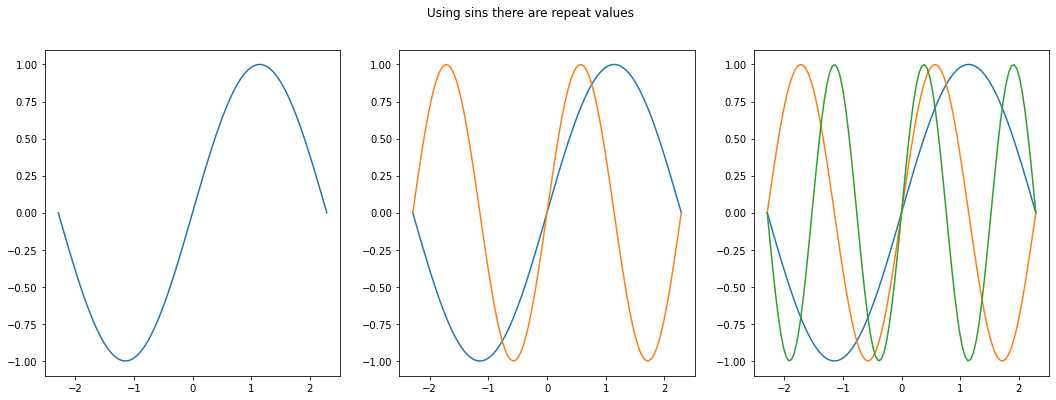

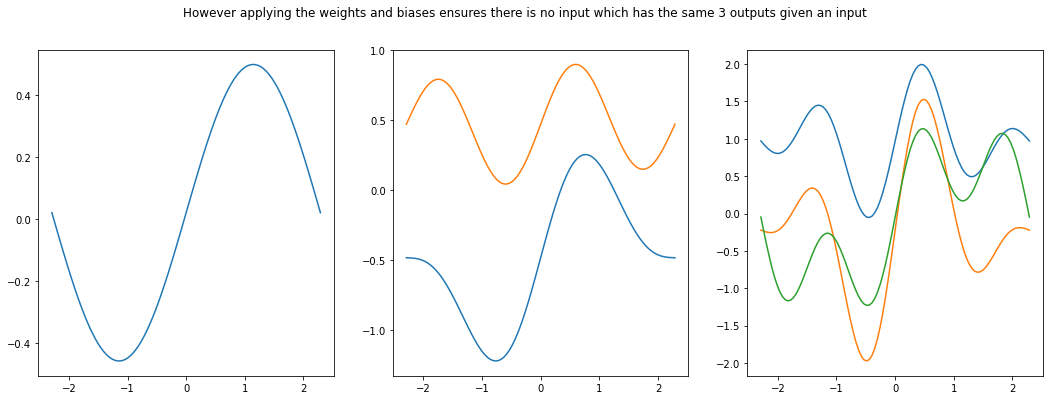

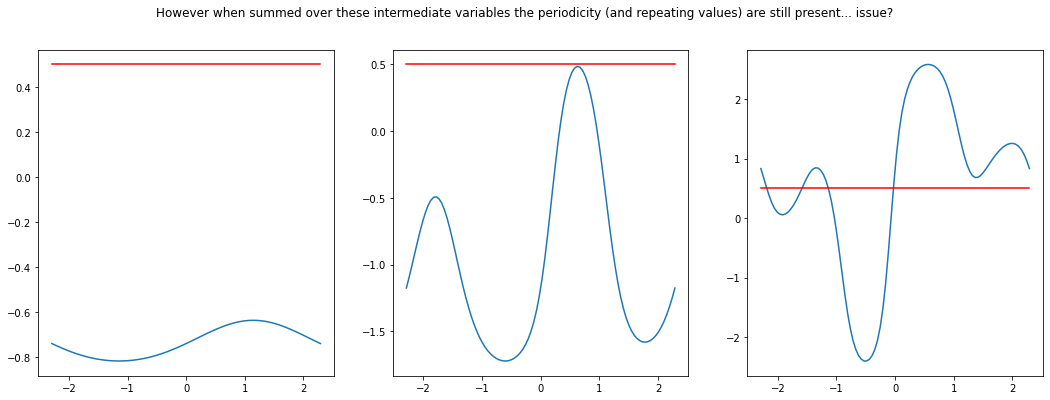

In [56]:
x = np.linspace(-mol.min_cell_width/2., mol.min_cell_width/2., 100)
n_sins = 4
w = np.random.uniform(0, 1, (n_sins, n_sins))

def sins(x, n_sins, L):
    return [np.sin((2.*i*np.pi/L) * x)[None, :] for i in range(1, n_sins+1)]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Using sins there are repeat values')
for ax, i in zip(axs, range(1, 4)):
    for y in sins(x, i, mol.min_cell_width):
        ax.plot(x, np.squeeze(y))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('However applying the weights and biases ensures there is no input which has the same 3 outputs given an input')
for ax, i in zip(axs, range(1, 4)):
    y = np.concatenate(sins(x, i, mol.min_cell_width), axis=0).T

    w = np.random.uniform(0, 1, (i, i))
    b = np.random.uniform(-1, 1, (i, 1))
    y = (y @ w).T + b
    for y_i in y:
        ax.plot(x, np.squeeze(y_i))


fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('However when summed over these intermediate variables the periodicity (and repeating values) are still present... issue?')
for ax, i in zip(axs, range(1, 4)):
    y = np.concatenate(sins(x, i, mol.min_cell_width), axis=0).T

    w = np.random.uniform(0, 1, (i, i))
    b = np.random.uniform(-1, 1, (i, 1))
    y = (y @ w).T + b
    ax.plot(x, np.tanh(y).sum(axis=0))
    ax.plot(x, [0.5 for i in x], color='r')

plt.show()

In [87]:
# plot the various experiments



TypeError: array() missing required argument 'object' (pos 1)

In [3]:
def load_pk(path):
    with open(path, 'rb') as f:
        x = pk.load(f)
    return x

def load_config_pk(path):
    with open(path, 'rb') as f:
        x = pk.load(f)
    new_config = {}
    for k, v in x.items():
        if type(v) == type(np.array([1.])):
            v = jnp.array(v)
        new_config[k] = v
        
    return new_config

def compute_ae_vectors_i(walkers: jnp.array,
                         r_atoms: jnp.array,
                         real_basis: jnp.array,
                         inv_real_basis: jnp.array) -> jnp.array:
    r_atoms = jnp.expand_dims(r_atoms, axis=0)
    walkers = jnp.expand_dims(walkers, axis=1)
    ae_vectors = walkers - r_atoms

    return ae_vectors 

def compute_ae_vectors_periodic_i(walkers: jnp.array,
                         r_atoms: jnp.array,
                         real_basis: jnp.array,
                         inv_real_basis: jnp.array) -> jnp.array:
    r_atoms = jnp.expand_dims(r_atoms, axis=0)
    walkers = jnp.expand_dims(walkers, axis=1)
    ae_vectors = walkers - r_atoms
    unit_cell_displacement = ae_vectors.dot(inv_real_basis)  # translate to the unit cell
    min_image_unit_cell_displacement_vectors = (2 * unit_cell_displacement).astype(int) * 1.  # 1 is length of unit cell put it here for clarity
    adjust = min_image_unit_cell_displacement_vectors.dot(real_basis)  # translate out of the unit cell
    r_atoms = lax.stop_gradient(r_atoms + adjust)
    ae_vectors = walkers - r_atoms
    return ae_vectors

def apply_minimum_image_convention(displacement_vectors, real_basis, inv_real_basis):
    '''
    pseudocode:
        - translate to the unit cell 
        - compute the distances
        - 2 * element distances will be maximum 0.999 (as always in the same cell)
        - int(2 * element distances) will either be 0, 1 or -1
    '''
    unit_cell_displacement = displacement_vectors.dot(inv_real_basis)  # translate to the unit cell
    min_image_unit_cell_displacement_vectors = unit_cell_displacement - lax.stop_gradient((2 * unit_cell_displacement).astype(int) * 1.)  # 1 is length of unit cell put it here for clarity
    min_image_displacement_vectors = min_image_unit_cell_displacement_vectors.dot(real_basis)  # translate out of the unit cell
    return min_image_displacement_vectors

def nans_in_tree(arg):
    arg, _ = tree_flatten(arg)
    print(jnp.array([jnp.isnan(x).any() for x in arg]).any())

def nans(arg):
    print(jnp.isnan(arg).any())

def walker_checks(mol, vwf, params, walkers, r_atoms):
    assert (walkers.dot(mol.inv_real_basis) > 0.).all()
    ae_vectors = walkers[:, None, ...] - r_atoms[None, None, ...]
    assert (ae_vectors.dot(mol.inv_real_basis) < 0.5).all()
    log_psi = vwf(params, walkers.squeeze(0))
    print('nans in log_psi ', jnp.isnan(log_psi).any())
    flat_params, map = tree_flatten(params)
    nans_in_params = jnp.array([jnp.isnan(x).any() for x in flat_params])
    print('nans in params ', nans_in_params.any())
    print('passed')


def compare(a, b):
    print(jnp.isclose(ae_vector, ae_vector_periodic, atol=1e-6).all())
    print(jnp.max(jnp.abs(a - b)))
    return jnp.abs(a - b).sum()
